# Multi-Period Optimization with Costs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import seaborn as sns

## Part 1 : Preparation

### Define Expected Return
Consider optimally trading a single stock over T = 30 days. Each period is one day, and you can trade once per day. The stock's daily return volatility is $\sigma$. Suppose your forecast is 50 basis points for the first period, and decays exponentially with half-life 5 days. This means that:
$$
\alpha_t = E[r_{t,t+1}]=50\times10^{-4}\times2^{-t/5}
$$

In [2]:
def generate_trajectory(T, HL, initial_strength):
    ret = []
    for i in range(T):
        ret.append(initial_strength*pow(10,-4)*pow(2,(-i-1)/HL))
    growth = np.array(ret) + np.ones(len(ret))
    growth = 40*growth.cumprod()
    return ret, growth

In [3]:
ret, growth = generate_trajectory(30,5, 50)

In [4]:
growth

array([40.17411011, 40.32634152, 40.45936884, 40.57555787, 40.67699676,
       40.76552522, 40.84276144, 40.91012688, 40.96886862, 41.02007971,
       41.06471727, 41.10361882, 41.13751666, 41.16705079, 41.19278019,
       41.21519294, 41.23471499, 41.25171797, 41.26652603, 41.27942181,
       41.29065176, 41.30043065, 41.30894569, 41.31635999, 41.32281567,
       41.32843655, 41.33333047, 41.33759138, 41.3413011 , 41.34453089])

In [5]:
ret

[0.004352752816480621,
 0.003789291416275995,
 0.0032987697769322356,
 0.0028717458874925874,
 0.0025,
 0.0021763764082403103,
 0.0018946457081379978,
 0.0016493848884661178,
 0.0014358729437462937,
 0.00125,
 0.001088188204120155,
 0.0009473228540689989,
 0.0008246924442330589,
 0.000717936471873147,
 0.000625,
 0.0005440941020600775,
 0.00047366142703449945,
 0.00041234622211652945,
 0.0003589682359365735,
 0.0003125,
 0.00027204705103003873,
 0.00023683071351724965,
 0.0002061731110582648,
 0.00017948411796828674,
 0.00015625,
 0.00013602352551501937,
 0.00011841535675862482,
 0.0001030865555291324,
 8.974205898414337e-05,
 7.8125e-05]

### Define Cost Function
Let c($\delta $) be the cost in dollars, of trading $\delta$ dollars of the stock. For selling, $\delta<0$. Following Almgren, we assume that :
$$
c(\delta)=PX(\frac{\gamma\sigma}{2}\frac{X}{V}(\frac{\Theta}{V})^{1/4}+sign(X)\eta\sigma\lvert \frac{X}{V} \rvert^{\beta}), X = \delta/P
$$

In this case, we suppose $P = 40 , V = 2\times10^6, \Theta = 2\times10^8, \sigma = 0.02, \gamma = 0.314, \eta = 0.142, \beta = 0.6$

In [6]:
def trading_cost(X, P, V=2*pow(10,6), Theta=2*pow(10,8), sigma = 0.02, gamma=0.314, eta=0.142, beta=0.6):
    c = pow(X,2)*(gamma*sigma/2/P/V*pow(Theta/V,0.25)) + X*np.sign(X)*eta*sigma*pow(abs(X/P/V),beta)
    return c

In [7]:
def trading_cost_deriv(X, P, V=2*pow(10,6), Theta=2*pow(10,8), sigma = 0.02, gamma=0.314, eta=0.142, beta=0.6):
    deriv = gamma*sigma/V/P*pow(Theta/V, 0.25)*X + eta*sigma/P/pow(V,beta)*(beta+1)*pow(abs(X),beta)
    return deriv

### Define P&L Function of all periods

For a trading path $x=(x_0, x_1,...,x_T)$ where $x_t$ denotes dollar holdings of the stock at time t, define the profit (also in dollars) as
$$
\pi(x)=\sum_{t=1}^{t}[x_tr_{t,t+1}-c(x_t - x_{t-1})]
$$
We want to find the sequence of positions $x_1,x_2, x_3,...,x_T$ that maximizes
$$
u(x_1,...,x_T)=\sum_{t=1}^{T}[x_t\alpha_t - \frac{\kappa}{2}\sigma^2x_{t}^2-c(x_t - x_{t-1})]
$$

In [8]:
def utility(alpha, price, x_now, x_pre, sigma = 0.02, kappa = pow(10,-7)):
    U = x_now*alpha - kappa/2*pow(sigma,2)*pow(x_now,2) - trading_cost(x_now - x_pre, price, sigma= sigma)
    return U

In [9]:
def utility_deriv(alpha, price, x_now, x_pre, sigma = 0.02, kappa = pow(10,-7)):
    deriv = alpha - kappa*pow(sigma,2)*x_now - trading_cost_deriv(x_now - x_pre, price)
    return deriv

In [10]:
def utility_sum(x_array, alpha_list, price_list, sigma=0.02, kappa=pow(10, -7)):
    ut_list = []
    for i in range(len(x_array) - 1):
        ut_list.append(utility(alpha = alpha_list[i], price = price_list[i], x_now = x_array[i+1], x_pre = x_array[i], sigma = sigma, kappa = kappa))
    return np.array(ut_list).sum()

### define profit

In [11]:
def profit(alpha, price, x_now, x_pre, sigma = 0.02):
    pro = x_now*alpha  - trading_cost(x_now - x_pre, price, sigma = sigma)
    return pro

In [12]:
def profit_sum(x_array, alpha_list, price_list, sigma = 0.02):
    pro_list = []
    for i in range(len(x_array) - 1):
        pro_list.append(profit(alpha = alpha_list[i], price = price_list[i], x_now = x_array[i+1], x_pre = x_array[i], sigma = sigma))
    return np.array(pro_list).sum()

## Part 2 : Maximize Utility

### Method 1 : Gradient Descent

In [13]:
### Method 1
def coordinate_gradient_descent(T,learning_rate=pow(10,8), epoch=500, threshold_1 = pow(10,0), threshold_2 = pow(10,-2)):
    ### Get ret and price
    ret, price = generate_trajectory(T, 5, 50)
    
    ### Initialize X_vector
    #x_vector = np.random.randint(low = 1, high = 100, size = T)
    x_vector = np.ones(T)*pow(10, 6)
    x_vector = np.append(0, x_vector)
    
    ### Initialize utility list
    U_list = []
    U_list.append(utility_sum(x_vector, ret, price))
    diff_whole = 100
    time = 1
    ### For whole trajectory
    while time < epoch and abs(diff_whole) > threshold_1:
        ### Gradient Descent for each coordinate
        for i in range(T):
            ### Initialize diff
            diff = 100
            iterator = 1
            ### Set threshold for error
            while abs(diff) > threshold_2:
                ### Compute previous Utility
                U_pre = utility(alpha = ret[i], price = price[i], x_now = x_vector[i+1], x_pre = x_vector[i])
                ### Gradient Descent for one time
                x_vector[i+1] = x_vector[i+1] + learning_rate/(10*iterator)*utility_deriv(alpha= ret[i], price = price[i], x_now=x_vector[i+1], x_pre=x_vector[i])
                ### Compute new Utility
                U_new = utility(alpha = ret[i], price = price[i], x_now = x_vector[i+1], x_pre = x_vector[i])
                ### Compute difference
                diff = U_new - U_pre
                iterator = iterator + 1
        
        U_list.append(utility_sum(x_vector, ret, price))
        ### Compute whole Utility diff
        diff_whole = U_list[time] - U_list[time-1]
        time = time + 1
        
    
    return x_vector, U_list     

In [14]:
start = time.time()
x_vecter_test, U_list = coordinate_gradient_descent(30)
end = time.time()
print('Computation time : ', end - start)

Computation time :  96.17976093292236


In [15]:
x_vecter_test

array([       0.        , 13876374.14476199, 24040001.5411758 ,
       30984329.61192445, 34351167.26753274, 36501648.44984663,
       37685022.74564239, 37985459.09972977, 37252201.48680983,
       35516463.83778121, 33051485.31902787, 30109106.57659036,
       26916803.72216336, 23668638.26205732, 20519206.9665508 ,
       17580514.99546515, 14922658.84755487, 12578193.29323603,
       10549892.14051111,  8820092.74218546,  7359766.32121311,
        6135553.24340084,  5114407.66379507,  4266021.03539974,
        3563827.05202156,  2984969.3944236 ,  2510139.20966772,
        2123125.797204  ,  1810251.2966592 ,  1560391.24561072,
        1364492.71804042])

In [16]:
np.array(U_list).max()

498798.37981460604

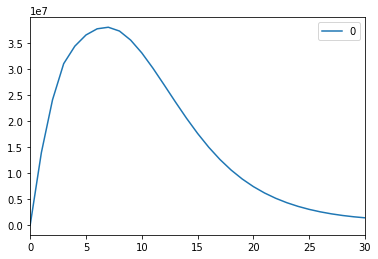

In [17]:
pd.DataFrame(x_vecter_test).plot()

### Why we don't use method 1?
Firstly, it's not a converge algorithm. We can only set the tolerance as the difference between the previous utility and new utility. We cannot guarantee that it falls into the global maximum point.

Secondly, it cannot take following path into consideration due to the difficulty to solve the analytical equation of the derivative of the sum utility function.(lots of iteration)

Thirdly, the speed of this algorithm is so low and the result is highly depend on parameters learning rate and the learning rate decay. I have tried lots of combinations, the result is still not stable and I can always find a better result by manipulate these two parameters.

### Method 2 : Golden-Section Search

In [18]:
### Method 2 
invphi = (math.sqrt(5) - 1) / 2 # 1/phi                                                                                                                     
invphi2 = (3 - math.sqrt(5)) / 2 # 1/phi^2                                                                                                                  

def gss(t, a, b, kappa, x_array, alpha_list, price_list, sigma, tol=1):
    ### Set interval
    (a,b)=(min(a,b),max(a,b))
    ### H is the length of the interval
    h = b - a
    ### Return when h is smaller than our tolerance
    if h <= tol: return (a+b)/2

    # required steps to achieve tolerance                                                                                                                   
    n = int(math.ceil(math.log(tol/h)/math.log(invphi)))

    c = a + invphi2 * h
    d = a + invphi * h
    
    x_array[t+1] = c
    yc = -utility_sum(x_array = x_array, alpha_list = alpha_list, price_list = price_list, sigma = sigma, kappa = kappa)
    x_array[t+1] = d
    yd = -utility_sum(x_array = x_array, alpha_list = alpha_list, price_list = price_list, sigma = sigma, kappa = kappa)

    for k in range(n-1):
        if yc < yd:
            b = d
            d = c
            yd = yc
            h = invphi*h
            c = a + invphi2 * h
            x_array[t+1] = c
            yc = -utility_sum(x_array = x_array, alpha_list = alpha_list, price_list = price_list, sigma = sigma, kappa = kappa)
        else:
            a = c
            c = d
            yc = yd
            h = invphi*h
            d = a + invphi * h
            x_array[t+1] = d
            yd = -utility_sum(x_array = x_array, alpha_list = alpha_list, price_list = price_list, sigma = sigma, kappa = kappa)

    if yc < yd:
        return (a + d)/2
    else:
        return (c + b)/2

In [19]:
def coordinate_golden_section(T, kappa, sigma, HL, initial_strength, tol=0.5):
    ### Get ret and price
    ret, price = generate_trajectory(T, HL, initial_strength)
    ### Initial x vector
    x_vector = np.ones(T)
    x_vector = np.append(0, x_vector)
    ### Optimize each x 
    U_list = []
    diff_whole = 100
    U_list.append(utility_sum(x_vector, ret, price, sigma, kappa))
    time = 0
    while abs(diff_whole) > tol: 
        for i in range(T):
            x_vector[i+1] = gss(t=i, a=-2*pow(10, 6)*price[i], b=2*pow(10, 6)*price[i], kappa=kappa, x_array=x_vector, alpha_list=ret, price_list=price, sigma=sigma)
        U_list.append(utility_sum(x_vector, ret, price, sigma, kappa))
        time = time + 1
        diff_whole = U_list[time] - U_list[time-1]
        
    
    return x_vector, utility_sum(x_vector, ret, price, sigma, kappa)

In [20]:
start = time.time()
x_vecter_test_2, U = coordinate_golden_section(30, pow(10, -7), 0.02, 5, 50, tol=1)
end = time.time()
print('Computation time : ', end - start)

Computation time :  10.280411958694458


In [21]:
pd.DataFrame(x_vecter_test_2, columns = ['Position'])

,Position
0,0.000000e+00
1,2.418138e+07
2,3.744317e+07
3,4.370275e+07
4,4.566597e+07
5,4.561161e+07
6,4.420198e+07
7,4.176099e+07
8,3.872295e+07
9,3.541377e+07


In [22]:
U

539830.3667162191

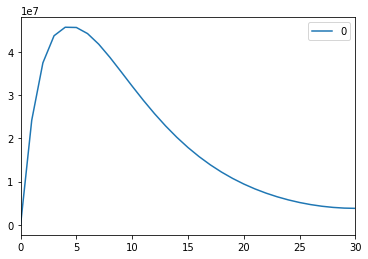

In [23]:
pd.DataFrame(x_vecter_test_2).plot()

### Why we use method 2 ?
Firstly, compare to method one, we don't need to solve the analytical equation, so it can take the following path into consideration. 

Secondly, the speed of this algorithm is much faster than method 1.

Thirdly, the result is stable and we get a significant higher sum utility compared with method 1.

### Why this method converge?

According to Tseng(2001), we can easily optimize
$$
f(x)=g(x)+\sum_{i = 1}^{n}h_{i}(x_{i})
$$
with g convex, differentiable and each $h_i$ convex, by coordinate-wise optimization. In this case, at each stage, the function (except trading cost term) is a convex function. 
Tseng's results also suggest an algorithm called blockwise coordinate descent(BCD).
Algorithm: Close an initial guess for x. Repeatedly iterate cyclically through i = 1, ..., N and perform the following optimization and update :
$$
x_i = argmin f(x_1, ..., x_{i-1}, w, x_{i+1},...x_{N})
$$
Tseng(2001) shows that for functions of the form above, any limit point of the BCD iteration is a minimizer of f. The order of cycling through coordinates is arbitrage; and we can use any scheme that visits each of {1,2,3,...,n} every M steps for fixed constant M. We can everywhere replace individual corrdinates with blocks of coordinates with blocks of coordinates. In this case, we can use each stage as a coordinate axis and run the algorithm over and over again and finally converage to a single path.

In [24]:
profit_sum(x_vecter_test_2, ret, growth)

927637.2194607937

## Part 3 : What will happen if we change kappa, half-life , initial strength and sigma?

### Define sharpe ratio

In [25]:
def sharpe_profit(x_array, alpha_list, price_list, sigma):
    pro_list = []
    for i in range(len(x_array) - 1):
        pro_list.append(profit(alpha = alpha_list[i], price = price_list[i], x_now = x_array[i+1], x_pre = x_array[i], sigma = sigma))
    pro = np.array(pro_list)
    return np.sqrt(252)*pro.sum()/np.sqrt(x_array.T @ x_array * pow(sigma,2)), pro.sum()

### Define funtion to change parameter and plot graph

In [26]:
def plot(x_, profit_, sharpe_, x_label):
    f, ax1 = plt.subplots()
    ax1.grid(True)
    ax1.set_ylabel('Expected Profit')
    ax1.set_xlabel(x_label)
    ax1.plot(x_, profit_, color = 'blue')
 
    ax2 = ax1.twinx() 
    ax2.set_ylabel('Sharpe Ratio')
    ax2.plot(x_, sharpe_, color = 'red')
 
    plt.show()

### Plot 1 : kappa

In [27]:
x_kappa = [pow(10, -7)*i for i in range(10)]

In [28]:
sharpe_list = []
profit_list = []
alpha_list, price_list = generate_trajectory(30, 5, 50)
for kappa in x_kappa:
    x_array, U = coordinate_golden_section(30,kappa,0.02, 5, 50)
    sharpe_reuslt, profit_result = sharpe_profit(x_array, alpha_list, price_list, 0.02)
    sharpe_list.append(sharpe_reuslt)
    profit_list.append(profit_result)

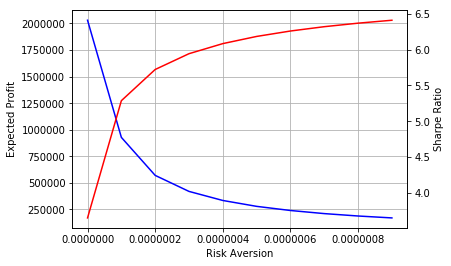

In [29]:
plot(x_kappa, profit_list, sharpe_list, 'Risk Aversion')

### Plot 2 : Half-Life

In [30]:
x_HL = [i+1 for i in range(10)]

In [31]:
sharpe_list = []
profit_list = []
for HL in x_HL:
    alpha_list, price_list = generate_trajectory(30, HL, 50)
    x_array, U = coordinate_golden_section(30,pow(10, -7),0.02, HL, 50)
    sharpe_reuslt, profit_result = sharpe_profit(x_array, alpha_list, price_list, 0.02)
    sharpe_list.append(sharpe_reuslt)
    profit_list.append(profit_result)

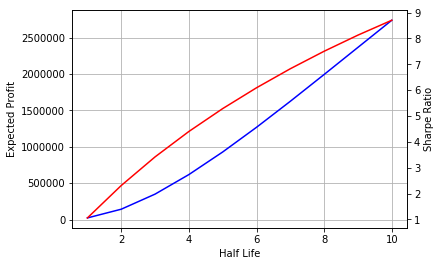

In [32]:
plot(x_HL, profit_list, sharpe_list, 'Half Life')

### Plot 3 : Initial Strength

In [33]:
x_IS = [20*i for i in np.arange(-10, 11, 1)]

In [34]:
sharpe_list = []
profit_list = []
for IS in x_IS:
    alpha_list, price_list = generate_trajectory(30, 5, IS)
    x_array, U = coordinate_golden_section(30,pow(10, -7),0.02, 5, IS)
    sharpe_reuslt, profit_result = sharpe_profit(x_array, alpha_list, price_list, 0.02)
    sharpe_list.append(sharpe_reuslt)
    profit_list.append(profit_result)

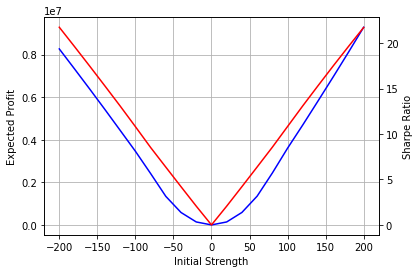

In [35]:
plot(x_IS, profit_list, sharpe_list, 'Initial Strength')

### Plot 4 : Sigma

In [36]:
x_sigma = [0.05*(i+1) for i in np.arange(0, 20, 1)]

In [37]:
sharpe_list = []
profit_list = []
for sigma in x_sigma:
    alpha_list, price_list = generate_trajectory(30, 5, 50)
    x_array, U = coordinate_golden_section(30,pow(10, -7),sigma, 5, 50)
    sharpe_reuslt, profit_result = sharpe_profit(x_array, alpha_list, price_list, sigma)
    sharpe_list.append(sharpe_reuslt)
    profit_list.append(profit_result)

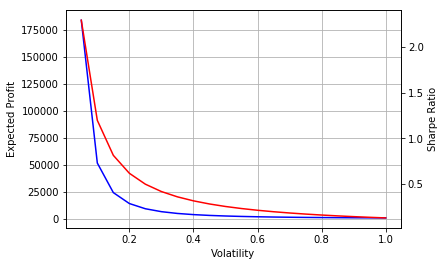

In [38]:
plot(x_sigma, profit_list, sharpe_list, 'Volatility')